# Notebook to make Fig. 5

PPCs for gaussian posteriors with different $\sigma_\mathrm{meas}$

In [40]:
# Import necessary packages & set-up plotting aesthetics

import numpy as np 
import pylab
import pandas as pd

import json
import random
import sys 
import os
import importlib

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.lines import Line2D

import fig_helper_functions 
from fig_helper_functions import *

style.use('plotting.mplstyle')

import seaborn as sns
sns.set_palette('colorblind')

### Load data

In [5]:
# True underlying population
f_root = '../Data/InjectedPopulationParameters/' 
true_pop = pd.read_json(f_root+'underlying_population3_lowSpinAligned_fullmassrange.json')

In [10]:
# Hyper-osterior samples 
model = 'betaPlusGaussian'
pop = '3'
nevent = '70' 
date = '092823'

# Which posteriors we want to look at
posterior_runs = ['gaussian_sigma_0.1', 'gaussian_sigma_0.3', 'gaussian_sigma_0.5']

# Make Dict
data_dict = {}

# Cycle through the different populations and no. of events
for pr in posterior_runs:
        
    print(pr)

    name = f"../Data/PopulationInferenceOutput/{model}/{date}_{model}_pop{pop}_{nevent}events_{pr}.json"

    with open(name, 'r') as f:
        data = json.load(f)

    data_dict[pr] = data

gaussian_sigma_0.1
gaussian_sigma_0.3
gaussian_sigma_0.5


In [11]:
# Predicted and observed draws 
date = '092823'
model = 'betaPlusGaussian'
f_root = '../Data/PopulationInferenceOutput/for_pp_plots/'
with open(f_root+f'{date}_{model}_pred_vs_obs_spins_dict_pp.json', 'r') as f: 
    pred_vs_obs_spins = json.load(f)

In [27]:
pred_vs_obs_spins['pop3']['70events']['gaussian_sigma_0.5'].keys()

dict_keys(['predicted', 'observed'])

### Calculations

KDE of true underlying pop

In [12]:
# Set up grids to evaluate KDEs on
cost_grid =  np.linspace(-1,1,500)

# Dict in which to store KDEs
cost_kde = get_KDE_dict_spins(true_pop)['cost']

Draws from hyper-posterior

In [15]:
# Make dict 
traces_dict = {}

# Choose a number of traces to draw
nTracesMax = 1000

# Cycle through runs
    
for pr in posterior_runs: 

    # Fetch data
    data = data_dict[pr]

    # Instantiate an array to hold a collection of traces
    nTraces = min(nTracesMax, len(data['mu_chi']['processed']))
    p_cost = np.zeros((nTraces,cost_grid.size))
    
    # For a random set of posterior samples, compute and store the corresponding probability densities across our grid
    random_indices = np.random.choice(np.arange(len(data['mu_chi']['processed'])), size=nTraces,replace=False)
    for i,ind in enumerate(random_indices):

        print(i, end='\r')

        mu_cost = data['mu_cost']['processed'][ind]
        sigma_cost = data['sigma_cost']['processed'][ind]

        # gaussian distribution for cos(theta)
        p_cost[i,:] = calculate_Gaussian_1D(cost_grid, mu_cost, sigma_cost, -1, 1)       

    # Add to dict 
    traces_dict[pr] = p_cost

Get fraction under-predicted

In [50]:
importlib.reload(fig_helper_functions)

percentages_dict = {}

for pr in posterior_runs: 
    
    print(pr)
    
    d = pred_vs_obs_spins['pop3']['70events'][pr]
    
    percentages_dict[pr] = get_fraction_underpredicted(d, nTrials=10, params=['cost1'])[1]
    
print('Done!')

gaussian_sigma_0.1
gaussian_sigma_0.3
gaussian_sigma_0.5
Done!


### Make Figure

In [67]:
# Labels corresponding to each pop
labels_dict = {
    'pop1':r'$\mathrm{\textsc{HighSpinPrecessing}}$', 
    'pop2':r'$\mathrm{\textsc{MediumSpin}}$', 
    'pop3':r'$\mathrm{\textsc{LowSpinAligned}}$'
}

# Colors corresponding to different numbers of events
colors_dict = {
    'gaussian_sigma_0.1':'C0',
    'gaussian_sigma_0.3':'C4',
    'gaussian_sigma_0.5':'C1'
}

# For legend
legend_handles = [Line2D([], [], color=c, label=r'$\sigma_\mathrm{meas} =$ '+l.split('_')[-1]) for l,c in colors_dict.items()]

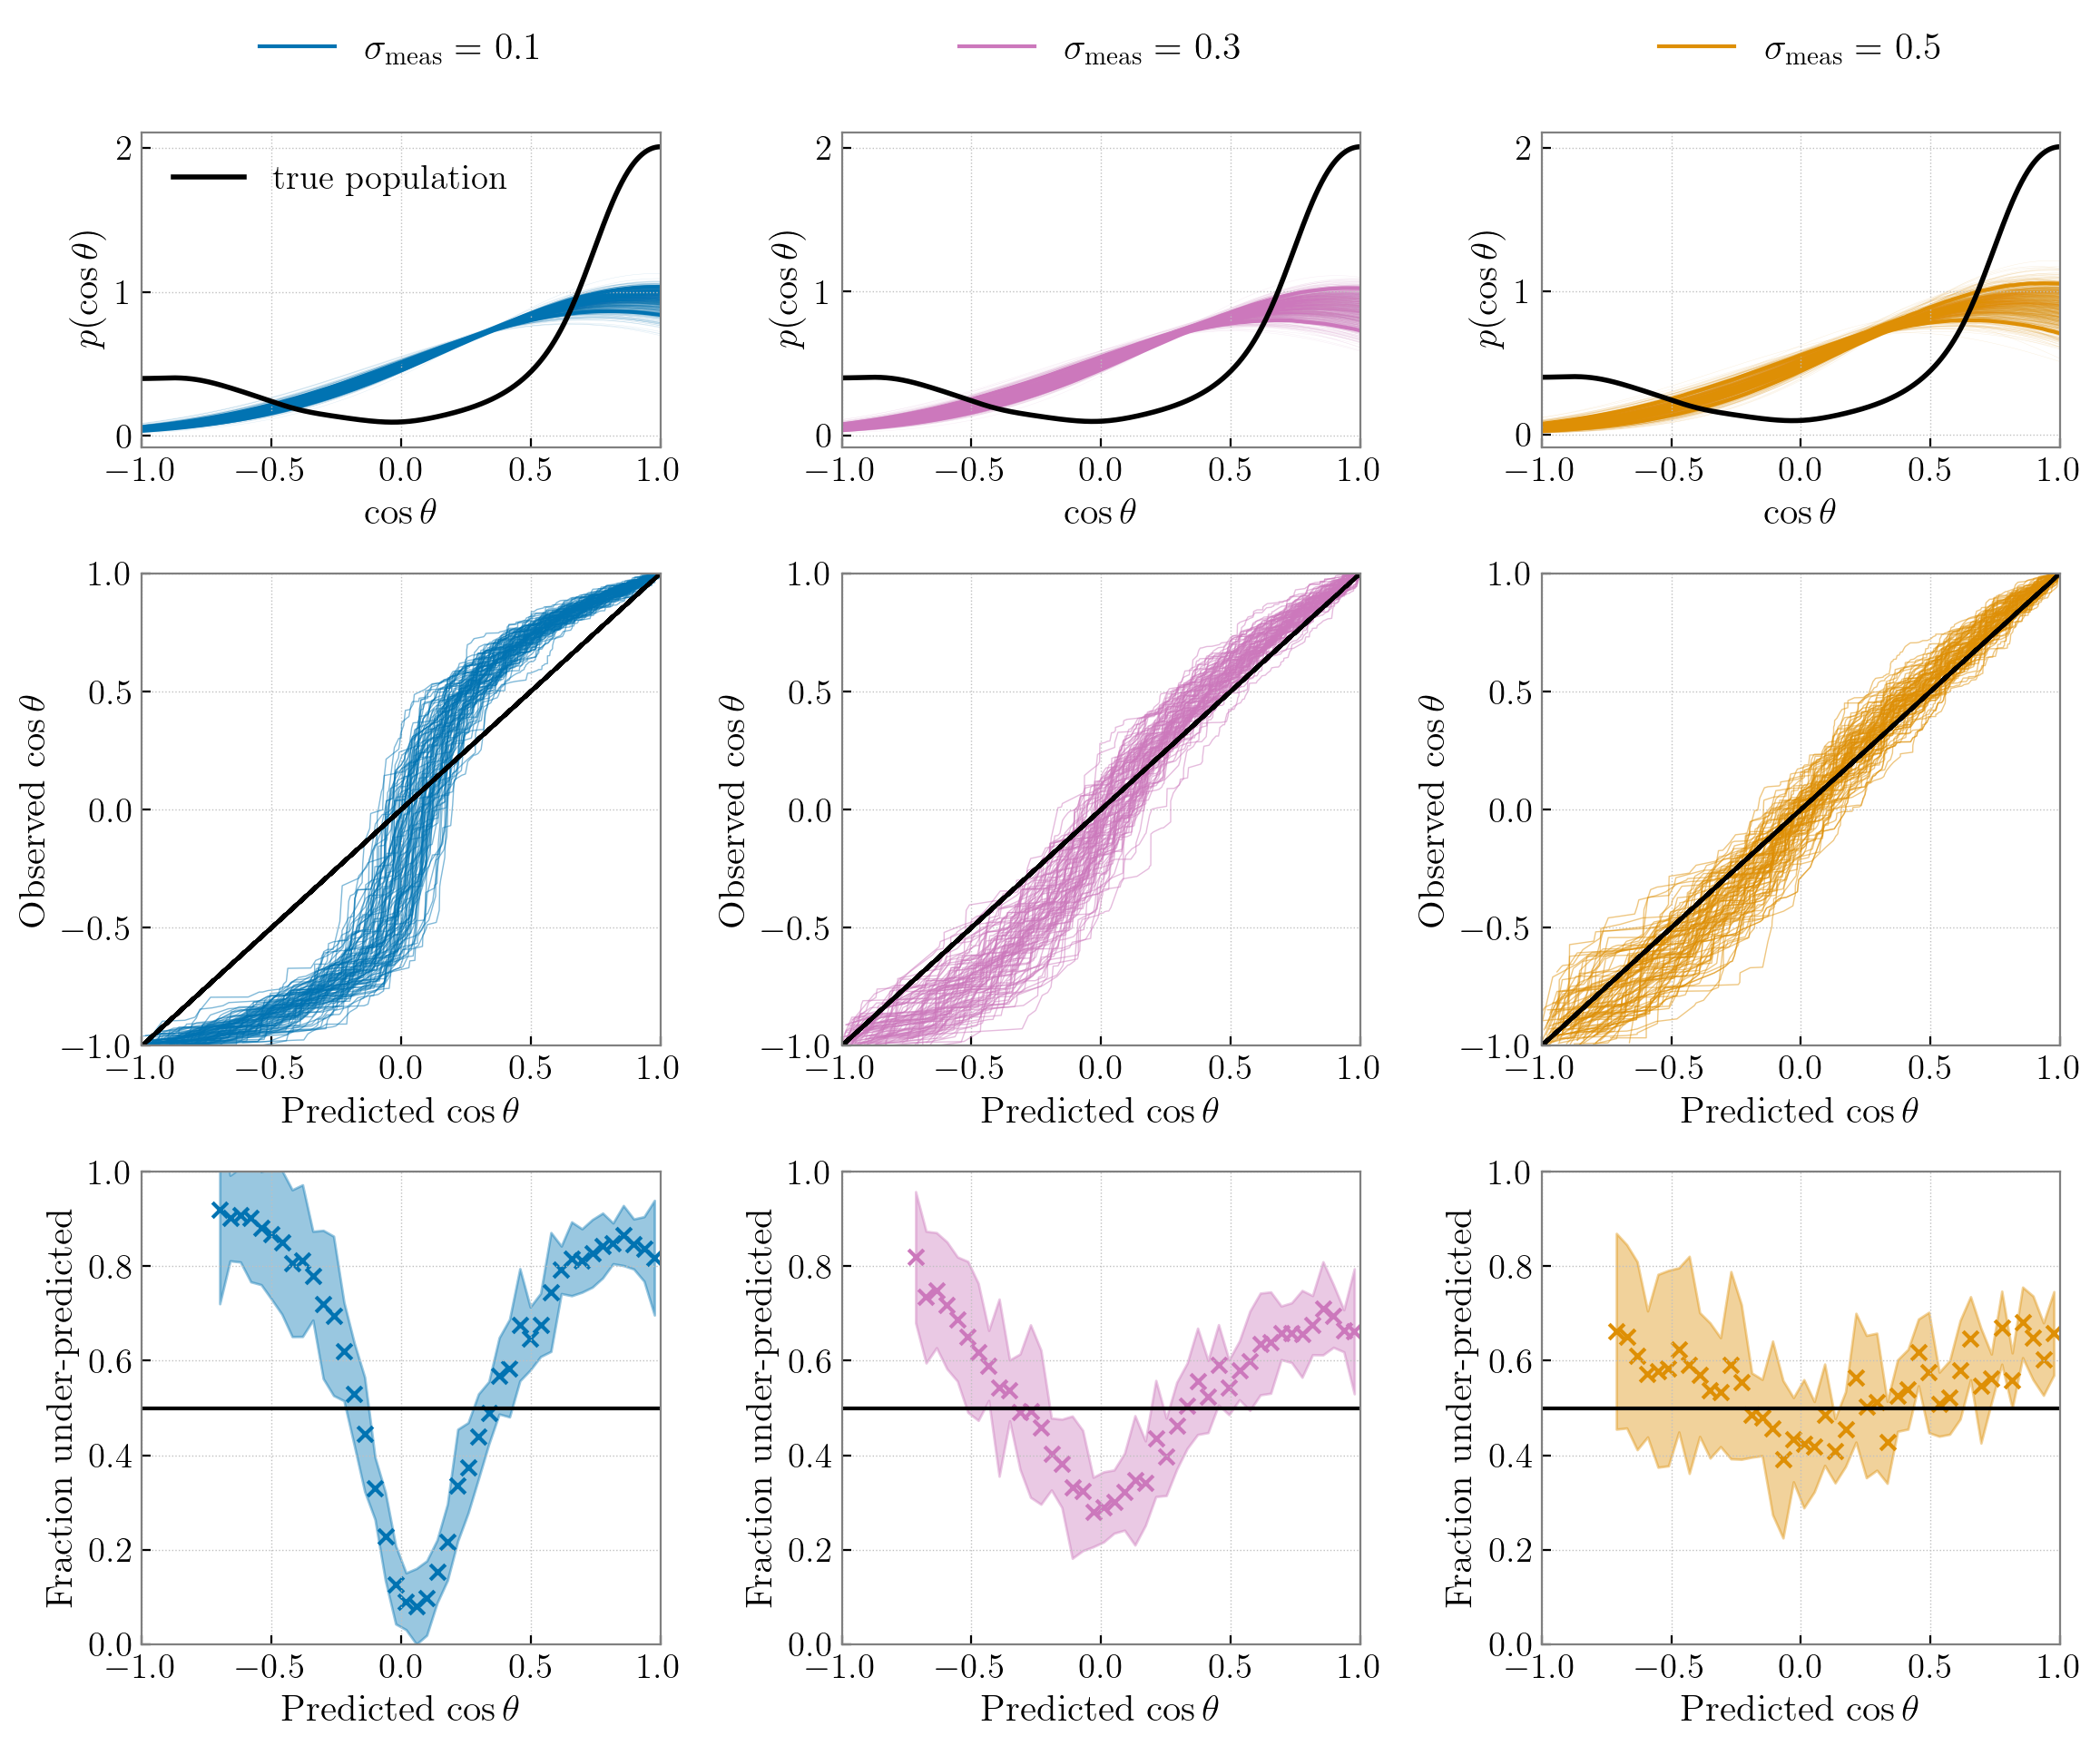

In [70]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15/1.1, 25/8/1.3*4.5), gridspec_kw={'height_ratios': [2, 3, 3]})

for k, posterior in enumerate(colors_dict.keys()):
    
    color = colors_dict[posterior]
    
    '''
    Top row: population traces
    '''
    # traces
    p_cost = traces_dict[posterior]
    axes[0][k].plot(cost_grid, p_cost.T, color=color, lw=0.15, alpha=0.15, zorder=1)
    axes[0][k].plot(cost_grid, np.quantile(p_cost,0.05,axis=0), color=color)
    axes[0][k].plot(cost_grid, np.quantile(p_cost,0.95,axis=0), color=color)
    
    # true underlying
    axes[0][k].plot(cost_grid, cost_kde, color='k', lw=2, label='true population')
    axes[0][k].set_xlim(-1,1)
    if k==0:
        axes[0][k].legend()
    
    axes[0][k].set_xlabel(r'$\cos\theta$', fontsize=15)
    axes[0][k].set_ylabel(r'$p(\cos\theta)$', fontsize=15)
    
    
    '''
    Middle row: PP plots
    '''
    for j in np.random.choice(1000, size=100):
        
        cost_pred = np.concatenate((pred_vs_obs_spins['pop3']['70events'][posterior]['predicted']['cost1'][j], 
                                    pred_vs_obs_spins['pop3']['70events'][posterior]['predicted']['cost2'][j]))
        cost_obs = np.concatenate((pred_vs_obs_spins['pop3']['70events'][posterior]['observed']['cost1'][j], 
                                   pred_vs_obs_spins['pop3']['70events'][posterior]['observed']['cost2'][j]))
        
        
        axes[1][k].plot(np.sort(cost_pred), np.sort(cost_obs), alpha=0.5, c=color, lw=0.5)
        
        bounds = [-1,1]
        axes[1][k].plot(bounds, bounds, color='k')
        axes[1][k].set_xlim(*bounds)
        axes[1][k].set_ylim(*bounds)
        
        axes[1][k].set_xlabel(r'Predicted $\cos\theta$', fontsize=15)
        axes[1][k].set_ylabel(r'Observed  $\cos\theta$', fontsize=15)
        
        axes[1][k].legend(handles=legend_handles[k:k+1], loc='lower center', bbox_to_anchor=(0.5, 2), fontsize=15)        
    
    '''
    Bottom row: fraction underpredicted
    '''
    
    axes[2][k].scatter(percentages_dict[posterior]['cost1']['x_vals'], 
                       percentages_dict[posterior]['cost1']['percentages'], 
                       color=color, marker='x')
    
    axes[2][k].fill_between(percentages_dict[posterior]['cost1']['x_vals'], 
                percentages_dict[posterior]['cost1']['percentages']+3*percentages_dict[posterior]['cost1']['error'], 
                percentages_dict[posterior]['cost1']['percentages']-3*percentages_dict[posterior]['cost1']['error'], 
                color=color, alpha=0.4)
    
    axes[2][k].plot([-1, 1], [0.5, 0.5], color='k')
    axes[2][k].set_xlim(-1,1)
    axes[2][k].set_ylim(0,1)
    
    # set axes labels
    axes[2][k].set_ylabel('Fraction under-predicted', fontsize=15)
    axes[2][k].set_xlabel(r'Predicted $\cos\theta$', fontsize=15)
    

# Grids
for ax in axes:
    for a in ax:
        a.grid(ls=':', color='silver', lw=0.5)
        a.spines['bottom'].set_color('gray')
        a.spines['top'].set_color('gray') 
        a.spines['right'].set_color('gray')
        a.spines['left'].set_color('gray')

plt.subplots_adjust(wspace=0.35, hspace=0.3)
plt.savefig('figure_05.pdf',bbox_inches='tight')
plt.show()